In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy

%matplotlib inline

In [2]:
df = pd.read_csv("/content/final_train.csv")
df_test = pd.read_csv("/content/final_test.csv")

import re
df['comment_text_clean'] = df['comment_text'].apply(lambda x: re.sub(r'\n', '', x))
df['comment_text_clean'] = df['comment_text_clean'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df['comment_text_clean'] = df['comment_text_clean'].apply(str.lower)

df_test['comment_text_clean'] = df_test['comment_text'].apply(lambda x: re.sub(r'\n', '', x))
df_test['comment_text_clean'] = df_test['comment_text_clean'].apply(lambda x: re.sub(r'[^\w\s]','',x))
df_test['comment_text_clean'] = df_test['comment_text_clean'].apply(str.lower)



# **tune hyperparameters**

**Based on the results from previous session we can see CountVectorizer works better than others algorithms**

In [13]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("logistic_reg", LogisticRegression(max_iter=1000))
    ])

print(model.get_params().keys())

params={
    # 'logistic_reg__penalty':[ 'l1', 'l2', 'elasticnet'],
    'logistic_reg__C':[i for i in range(1,6,2)],
    'logistic_reg__max_iter':[1000, 10000, 10000],
    'vectorizer__ngram_range':[(1,1), (1,2),(2,2)]
}

grid_search = GridSearchCV(model,
                         param_grid=params,
                         cv=5,
                         verbose=1, 
                         )

grid_search.fit(df["comment_text_clean"], df["toxic"])

print(grid_search.best_params_)
print(grid_search.best_score_)

dict_keys(['memory', 'steps', 'verbose', 'vectorizer', 'logistic_reg', 'vectorizer__analyzer', 'vectorizer__binary', 'vectorizer__decode_error', 'vectorizer__dtype', 'vectorizer__encoding', 'vectorizer__input', 'vectorizer__lowercase', 'vectorizer__max_df', 'vectorizer__max_features', 'vectorizer__min_df', 'vectorizer__ngram_range', 'vectorizer__preprocessor', 'vectorizer__stop_words', 'vectorizer__strip_accents', 'vectorizer__token_pattern', 'vectorizer__tokenizer', 'vectorizer__vocabulary', 'logistic_reg__C', 'logistic_reg__class_weight', 'logistic_reg__dual', 'logistic_reg__fit_intercept', 'logistic_reg__intercept_scaling', 'logistic_reg__l1_ratio', 'logistic_reg__max_iter', 'logistic_reg__multi_class', 'logistic_reg__n_jobs', 'logistic_reg__penalty', 'logistic_reg__random_state', 'logistic_reg__solver', 'logistic_reg__tol', 'logistic_reg__verbose', 'logistic_reg__warm_start'])
Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'logistic_reg__C': 1, 'logistic_reg__max_it

In [15]:
model = Pipeline([
        ("vectorizer", CountVectorizer(ngram_range=(1,1))),
        ("logistic_reg", LogisticRegression(max_iter=1000, C=1))
    ])

model.fit(df["comment_text_clean"], df["toxic"])
y_pred = model.predict_proba(df_test["comment_text_clean"])[:,1]
print("FINAL TESTING")
print("ROC AUC = ",roc_auc_score(df_test["toxic"].values,  y_pred))

FINAL TESTING
ROC AUC =  0.9399833060280476


Hyperparamets didn't change, so the average voting in an ensemble is better than individual model 

#**RNN**

In [14]:
torch.manual_seed(42)
torch.backends.cuda.deterministic = True

In [ ]:
class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        # TODO: What is bidirectional ? Try unidirectional
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Linear(
            rnn_channels * 2 if bidirectional else rnn_channels, 
            out_channels, 
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    # TODO: Is it a best solution? Read about collate_fn - https://pytorch.org/docs/stable/data.html
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(self.targets[idx]).float()
        )
    
    def __len__(self):
        return len(self.texts)

In [ ]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(df["comment_text_clean"]), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [ ]:
criteria = [col for col in df.columns[3:-2]]
print(criteria)

In [ ]:
df["strat_feature"] = df[criteria].apply(
    lambda x: reduce(lambda x, y: str(x) + str(y), x), axis=1
)

In [ ]:
small_strat_groups = df["strat_feature"].value_counts()[
    # Why do I have 5 here ? 
    df["strat_feature"].value_counts() < 5
].index
df.loc[df["strat_feature"].isin(small_strat_groups), "strat_feature"] = "-1"
# df["strat_feature"].value_counts()

In [ ]:
# skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
# folds_train_test_ids = [el for el in skf.split(df, df["toxic"])]

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(df, df["strat_feature"])]

In [ ]:
df.iloc[folds_train_test_ids[0][1]]["comment_text_clean"].to_list()

In [ ]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    out_channels=len(criteria),
    average_type="mean"
).to("cuda")

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
# TODO: Read more about Optimizers https://pytorch.org/docs/stable/optim.html
# TODO: Try to tune hyperparameters here
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
# TODO: Read more about schedulers https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [ ]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    # TODO: Read about train and eval modes on official Torch Docs. What do they change ?
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                # TODO: Is mean a best choice ?
                # 2. Compute Backward path
                loss.mean().backward()
                # TODO: Try gradient clipping 
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                # 3. Apply gradient descent `on steroids` 
                optimizer.step()
                
            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets

def print_losses(input):
    # for cls_idx, cls_name in enumerate(criteria):
    #     print(f"{tgt_col} BCE loss: {input[:,cls_idx].mean()}")
    print(f"Result BCE loss: {input.mean()}")

In [ ]:
def comp_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]
    if verbose:
        # for ra, tgt_col in zip(class_roc_aucs, criteria):
        #     print(f"{tgt_col} Roc Auc: {ra}")
        print(f"Result Roc Auc: {np.mean(class_roc_aucs)}")
    return class_roc_aucs, np.mean(class_roc_aucs)

# **Cross Validation for RNN**

In [ ]:
n_epochs = 3

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = [] 


for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
  
  print(f'\n--- FOLD {fold_id} ----')

  train_torch_dataset = TextDataset(
      # texts=df.iloc[folds_train_test_ids[train_ids][0]]["comment_text_clean"].to_list(),
      texts=df["comment_text_clean"].iloc[train_ids].to_list(),

      targets=df[criteria].iloc[train_ids].values,
      dataset_vocab=vocab,
      dataset_tokenizer=tokenizer,
      max_length=300,
  )
  train_torch_dataloader = torch.utils.data.DataLoader(
      train_torch_dataset,
      batch_size=32,
      shuffle=True,
      drop_last=True,
      num_workers=8,
      pin_memory=True
  )

  valid_torch_dataset = TextDataset(
      texts=df["comment_text_clean"].iloc[test_ids].to_list(),
      targets=df[criteria].iloc[test_ids].values,
      dataset_vocab=vocab,
      dataset_tokenizer=tokenizer,
      max_length=300,
      trim_policy="first"
  )
  valid_torch_dataloader = torch.utils.data.DataLoader(
      valid_torch_dataset,
      batch_size=32,
      shuffle=False,
      drop_last=False,
      num_workers=8,
      pin_memory=True
  )

 
    
            
  train_all_epoch_labels = []
  train_all_epoch_losses = []
  train_all_epoch_targets = []
  valid_all_epoch_labels = []
  valid_all_epoch_losses = []
  valid_all_epoch_targets = []
  valid_roc_aucs = []
  train_roc_aucs = []

  best_metric = - np.inf
  best_model_state_dict = None

  for epoch in range(1, n_epochs + 1):
      print(f"Starting Epoch {epoch}")
      # 1.1 Iterate over all train dataset and update model weights
      print("Train phase")
      train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
          dataloader=train_torch_dataloader, 
          inp_model=nn_model,
          inp_optimizer=optimizer,
          inp_criterion=criterion,
          device="cuda",
          mode="train"
      )
      # 1.2 Compute and print train metrics
      print("Train metrics")
      _, train_roc_auc = comp_metric(
          train_epoch_targets, 
          train_epoch_labels
      )
      print("Train BCE losses")
      print_losses(train_epoch_losses)
      # 2.1 Iterate over all valid dataset and compute predictions
      print("Valid phase")
      valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
          dataloader=valid_torch_dataloader, 
          inp_model=nn_model,
          inp_optimizer=optimizer,
          inp_criterion=criterion,
          device="cuda",
          mode="eval"
      )
      # 2.2 Compute and print valid metrics
      print("Valid metrics")
      _, valid_roc_auc = comp_metric(
          valid_epoch_targets, 
          valid_epoch_labels
      )
      print("Valid BCE losses")
      print_losses(valid_epoch_losses)
      # 3. Update learning rate (if needed)
      scheduler.step(valid_roc_auc)
      # 4. Save best model
      if valid_roc_auc > best_metric:
          best_metric = valid_roc_auc
          best_model_state_dict = deepcopy(nn_model.state_dict())
          torch.save(nn_model, f'model{epoch}.pth')

      # 5. Accumulate all stats  
      train_all_epoch_labels.append(train_epoch_labels)
      train_all_epoch_losses.append(train_epoch_losses)
      train_all_epoch_targets.append(train_epoch_targets)
      valid_all_epoch_labels.append(valid_epoch_labels)
      valid_all_epoch_losses.append(valid_epoch_losses)
      valid_all_epoch_targets.append(valid_epoch_targets)
      valid_roc_aucs.append(valid_roc_auc)
      train_roc_aucs.append(train_roc_auc)

  all_train_preds.append(train_all_epoch_labels[-1])
  all_test_preds.append(valid_all_epoch_labels[-1])
  all_train_targets.append(train_all_epoch_targets[-1])
  all_test_targets.append(valid_all_epoch_targets[-1])   


all_train_preds=np.concatenate(all_train_preds)
all_test_preds=np.concatenate(all_test_preds)
all_train_targets=np.concatenate(all_train_targets)
all_test_targets=np.concatenate(all_test_targets)

print()
# print(len(all_train_preds[0]), len(all_test_preds[0]))
print(f"OOF Valid Score: {comp_metric(all_test_targets, all_test_preds)}")
print(f"OOF Train Score: {comp_metric(all_train_targets, all_train_preds)}")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



--- FOLD 0 ----
Starting Epoch 1
Train phase


100%|██████████| 521/521 [00:46<00:00, 11.18it/s]


Train metrics
Result Roc Auc: 0.8822944328124775
Train BCE losses
Result BCE loss: 0.20029960572719574
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 30.67it/s]


Valid metrics
Result Roc Auc: 0.9447054498206459
Valid BCE losses
Result BCE loss: 0.15239743888378143
Starting Epoch 2
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.15it/s]


Train metrics
Result Roc Auc: 0.9630537905863832
Train BCE losses
Result BCE loss: 0.11804868280887604
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 30.64it/s]


Valid metrics
Result Roc Auc: 0.9579179273170411
Valid BCE losses
Result BCE loss: 0.14365479350090027
Starting Epoch 3
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.31it/s]


Train metrics
Result Roc Auc: 0.9859211062841615
Train BCE losses
Result BCE loss: 0.07333429902791977
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 29.23it/s]


Valid metrics
Result Roc Auc: 0.9593331647554415
Valid BCE losses
Result BCE loss: 0.16927075386047363


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



--- FOLD 1 ----
Starting Epoch 1
Train phase


100%|██████████| 521/521 [00:46<00:00, 11.23it/s]


Train metrics
Result Roc Auc: 0.9850790625785949
Train BCE losses
Result BCE loss: 0.07944446057081223
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.81it/s]


Valid metrics
Result Roc Auc: 0.9943070828996448
Valid BCE losses
Result BCE loss: 0.05972656235098839
Starting Epoch 2
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.25it/s]


Train metrics
Result Roc Auc: 0.9968749746259693
Train BCE losses
Result BCE loss: 0.03533884137868881
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.16it/s]


Valid metrics
Result Roc Auc: 0.9941610680175359
Valid BCE losses
Result BCE loss: 0.05417603254318237
Starting Epoch 3
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.21it/s]


Train metrics
Result Roc Auc: 0.9990602826726885
Train BCE losses
Result BCE loss: 0.016996506601572037
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 29.01it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Valid metrics
Result Roc Auc: 0.993703673058245
Valid BCE losses
Result BCE loss: 0.06124541535973549
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.

--- FOLD 2 ----
Starting Epoch 1
Train phase


100%|██████████| 521/521 [00:46<00:00, 11.25it/s]


Train metrics
Result Roc Auc: 0.9987721974936233
Train BCE losses
Result BCE loss: 0.020664410665631294
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 29.09it/s]


Valid metrics
Result Roc Auc: 0.9997489540329063
Valid BCE losses
Result BCE loss: 0.010737734846770763
Starting Epoch 2
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.16it/s]


Train metrics
Result Roc Auc: 0.9998695729857792
Train BCE losses
Result BCE loss: 0.006786600686609745
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.66it/s]


Valid metrics
Result Roc Auc: 0.9996953199129127
Valid BCE losses
Result BCE loss: 0.00851848442107439
Starting Epoch 3
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.24it/s]


Train metrics
Result Roc Auc: 0.9999788671886037
Train BCE losses
Result BCE loss: 0.003409763565286994
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.33it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Valid metrics
Result Roc Auc: 0.9996537909134974
Valid BCE losses
Result BCE loss: 0.008688394911587238
Epoch 00009: reducing learning rate of group 0 to 2.5000e-04.

--- FOLD 3 ----
Starting Epoch 1
Train phase


100%|██████████| 521/521 [00:46<00:00, 11.24it/s]


Train metrics
Result Roc Auc: 0.9999148916387508
Train BCE losses
Result BCE loss: 0.0038018140476197004
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.54it/s]


Valid metrics
Result Roc Auc: 0.9999176399900558
Valid BCE losses
Result BCE loss: 0.003861723467707634
Starting Epoch 2
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.22it/s]


Train metrics
Result Roc Auc: 0.9999850185012555
Train BCE losses
Result BCE loss: 0.002083228901028633
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.47it/s]


Valid metrics
Result Roc Auc: 0.9999335386322846
Valid BCE losses
Result BCE loss: 0.0034261750988662243
Starting Epoch 3
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.22it/s]


Train metrics
Result Roc Auc: 0.9999948792100737
Train BCE losses
Result BCE loss: 0.0015576655277982354
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.38it/s]


Valid metrics
Result Roc Auc: 0.9999354672879844
Valid BCE losses
Result BCE loss: 0.00380890816450119
Epoch 00012: reducing learning rate of group 0 to 1.2500e-04.


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



--- FOLD 4 ----
Starting Epoch 1
Train phase


100%|██████████| 521/521 [00:46<00:00, 11.22it/s]


Train metrics
Result Roc Auc: 0.9999845221994574
Train BCE losses
Result BCE loss: 0.0016289324266836047
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 29.03it/s]


Valid metrics
Result Roc Auc: 0.9999976693136409
Valid BCE losses
Result BCE loss: 0.0011426060227677226
Starting Epoch 2
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.23it/s]


Train metrics
Result Roc Auc: 0.9999913880578498
Train BCE losses
Result BCE loss: 0.0013641525292769074
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.48it/s]


Valid metrics
Result Roc Auc: 0.9999975873306127
Valid BCE losses
Result BCE loss: 0.0013500022469088435
Epoch 00014: reducing learning rate of group 0 to 6.2500e-05.
Starting Epoch 3
Train phase


  0%|          | 0/521 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 521/521 [00:46<00:00, 11.23it/s]


Train metrics
Result Roc Auc: 0.9999847011201985
Train BCE losses
Result BCE loss: 0.001230661990121007
Valid phase


  0%|          | 0/131 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 131/131 [00:04<00:00, 28.44it/s]

Valid metrics
Result Roc Auc: 0.9999973125246688
Valid BCE losses
Result BCE loss: 0.0014154314994812012

Result Roc Auc: 0.995799867436682
OOF Valid Score: ([0.9962458421546708, 0.9934036251599634, 0.9964729586841012, 0.9983774461591568, 0.9944994650255181], 0.995799867436682)
Result Roc Auc: 0.9990191061023372
OOF Train Score: ([0.9996156984104958, 0.9982256479594821, 0.9993448622343333, 0.9989323109923147, 0.9989770109150605], 0.9990191061023372)


**testing stage**

In [ ]:
# nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=df_test["comment_text_clean"].to_list(),
    targets=df_test[criteria].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)


models = [UniversalRNN(
    num_embeddings=len(vocab),
    out_channels=len(criteria),
    average_type="mean"
).to("cuda") for i in range(5)]  

test_pred = []
for i, m in enumerate(models):
    m = (torch.load(f"model{i+1}.pth"))
    test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device="cuda",
    mode="eval"
)    
    test_pred.append(test_labels)

y_pred = np.stack(test_pred,axis=0).mean(0)
print("\n\nFINAL TESTING")

comp_metric(
    test_targets, 
    test_labels
);


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 653/653 [00:20<00:00, 31.87it/s]



FINAL TESTING
Result Roc Auc: 0.9596808913234585


# **Dynamic plot for stats while RNN training**

In [15]:
from pandas.io.formats.info import DataFrameInfo

train_torch_dataset = TextDataset(
    texts=df.iloc[folds_train_test_ids[0][0]]["comment_text_clean"].to_list(),
    targets=df.iloc[folds_train_test_ids[0][0]][criteria].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
)
# TODO: Read more about DataLoader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=64,
    # It is highly important to shuffle data while training. Why ?
    shuffle=True,
    # It is important to drop last batch while training. Why ?
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=df.iloc[folds_train_test_ids[0][1]]["comment_text_clean"].to_list(),
    targets=df.iloc[folds_train_test_ids[0][1]][criteria].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=64,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Starting Epoch 1
Train phase


100%|██████████| 260/260 [00:41<00:00,  6.29it/s]


Train metrics
toxic Roc Auc: 0.8591041526528984
severe_toxic Roc Auc: 0.8946765860715024
obscene Roc Auc: 0.8867836945647474
threat Roc Auc: 0.7310612959365388
insult Roc Auc: 0.8721647507891067
Result Roc Auc: 0.8487580960029588
Train BCE losses
Result BCE loss: 0.22071819007396698
Valid phase


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 66/66 [00:03<00:00, 16.55it/s]

Valid metrics
toxic Roc Auc: 0.9378365939440567
severe_toxic Roc Auc: 0.9458369643023872
obscene Roc Auc: 0.950566805805269
threat Roc Auc: 0.8867376573088092
insult Roc Auc: 0.9395681374251643
Result Roc Auc: 0.9321092317571372
Valid BCE losses
Result BCE loss: 0.16118621826171875


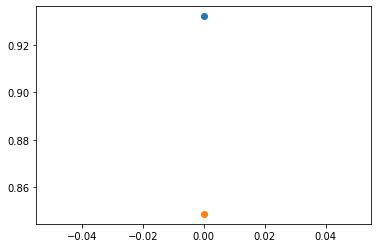

Starting Epoch 2
Train phase


  0%|          | 0/260 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 260/260 [00:40<00:00,  6.48it/s]


Train metrics
toxic Roc Auc: 0.9627859079199973
severe_toxic Roc Auc: 0.9627977401491196
obscene Roc Auc: 0.9705728000683902
threat Roc Auc: 0.8965766980085853
insult Roc Auc: 0.9576153871505475
Result Roc Auc: 0.9500697066593279
Train BCE losses
Result BCE loss: 0.13147395849227905
Valid phase


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 66/66 [00:03<00:00, 17.74it/s]

Valid metrics
toxic Roc Auc: 0.9529737044567786
severe_toxic Roc Auc: 0.9527189474339423
obscene Roc Auc: 0.9598438808805335
threat Roc Auc: 0.9525934847700309
insult Roc Auc: 0.9469429380809926
Result Roc Auc: 0.9530145911244556
Valid BCE losses
Result BCE loss: 0.14793850481510162


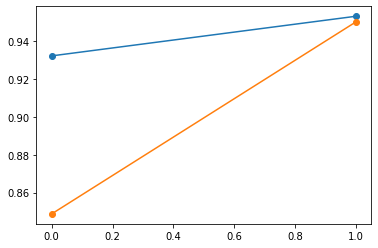

Starting Epoch 3
Train phase


  0%|          | 0/260 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 260/260 [00:42<00:00,  6.16it/s]


Train metrics
toxic Roc Auc: 0.9874635447070595
severe_toxic Roc Auc: 0.9737134660993304
obscene Roc Auc: 0.9855915284533114
threat Roc Auc: 0.9548852020166978
insult Roc Auc: 0.9784557259323478
Result Roc Auc: 0.9760218934417493
Train BCE losses
Result BCE loss: 0.09269198775291443
Valid phase


  0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 66/66 [00:04<00:00, 14.27it/s]

Valid metrics
toxic Roc Auc: 0.9515420124196295
severe_toxic Roc Auc: 0.9533783573496001
obscene Roc Auc: 0.9616794940541904
threat Roc Auc: 0.9685269816970216
insult Roc Auc: 0.9476805582010285
Result Roc Auc: 0.9565614807442939
Valid BCE losses
Result BCE loss: 0.16642232239246368


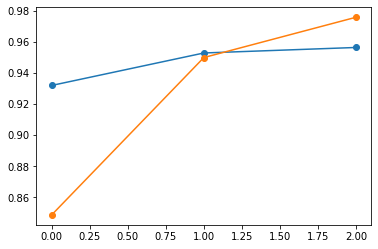

<Figure size 432x288 with 0 Axes>

In [16]:
from collections import deque

n_epochs = 3

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

que = deque(maxlen = 10)
que_2 = deque(maxlen = 10)

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="train"
    )
    print("Train metrics")
    _, train_roc_auc = comp_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="eval"
    )
    print("Valid metrics")
    _, valid_roc_auc = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    scheduler.step(valid_roc_auc)
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())

      

    que.append(valid_roc_auc)
    que_2.append(train_roc_auc)
    
    # PLOTTING THE POINTS
    plt.plot(que)
    plt.plot(que_2)
    plt.scatter(range(len(que)),que)
    plt.scatter(range(len(que_2)),que_2)
    
    plt.draw()
    plt.pause(0.1)
    plt.clf()

    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses.mean())
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses.mean())
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)

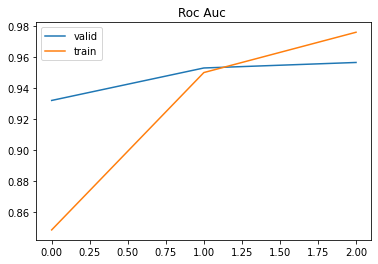

In [17]:
plt.title("Roc Auc ")
plt.plot(valid_roc_aucs, label="valid")
plt.plot(train_roc_aucs, label="train")
plt.legend()
plt.show()

**Loss vizualization**

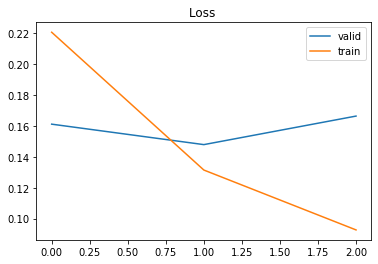

In [18]:
plt.title("Loss ")
plt.plot(valid_all_epoch_losses, label="valid")
plt.plot(train_all_epoch_losses, label="train")
plt.legend()
plt.show()


**Classification report**

In [19]:
test_torch_dataset = TextDataset(
    texts=df_test["comment_text_clean"].to_list(),
    targets=df_test[criteria].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)


test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device="cuda",
    mode="eval"
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 653/653 [00:19<00:00, 33.86it/s]


In [35]:
def comp_metric_accuracy_score(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    class_accuracy_scores = [accuracy_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]
    if verbose:
        for ra, tgt_col in zip(class_accuracy_scores, criteria):
            print(f"{tgt_col} accuracy score: {ra}")
        print(f"Result accuracy score: {np.mean(class_accuracy_scores)}")
    return class_accuracy_scores, np.mean(class_accuracy_scores)

toxic Roc Auc: 0.9440562537232972
severe_toxic Roc Auc: 0.9758793534586648
obscene Roc Auc: 0.962598605760411
threat Roc Auc: 0.9737369066775174
insult Roc Auc: 0.9571218085188272
Result Roc Auc: 0.9626785856277434
ROC-AUC: 0.9626785856277434

toxic accuracy score: 0.8484166147654865
severe_toxic accuracy score: 0.9784410482441431
obscene accuracy score: 0.9449049010683658
threat accuracy score: 0.9959277535572271
insult accuracy score: 0.9492646002012168
Result accuracy score: 0.9433909835672878
Accuracy : 0.9433909835672878


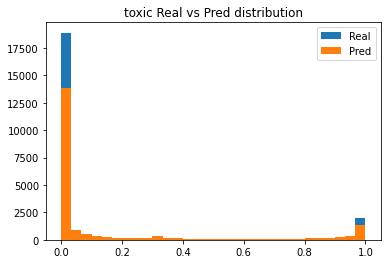

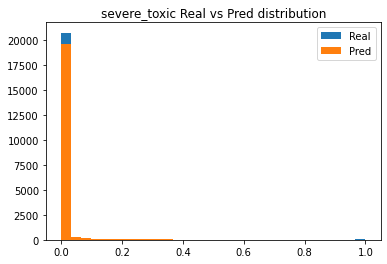

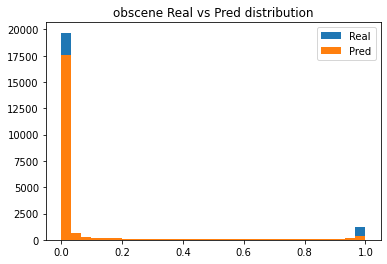

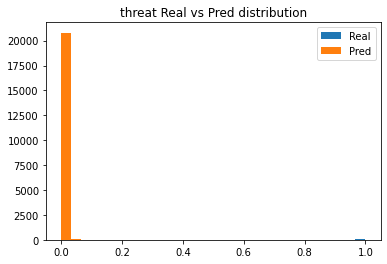

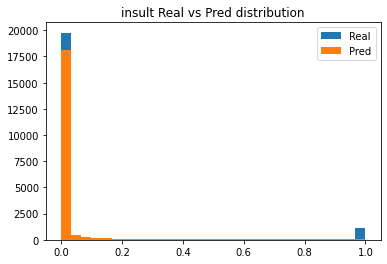


confusion matrix
 [[[15921  2958]
  [  206  1788]]

 [[20323   422]
  [   28   100]]

 [[18770   918]
  [  232   953]]

 [[20783    12]
  [   73     5]]

 [[19029   740]
  [  319   785]]]


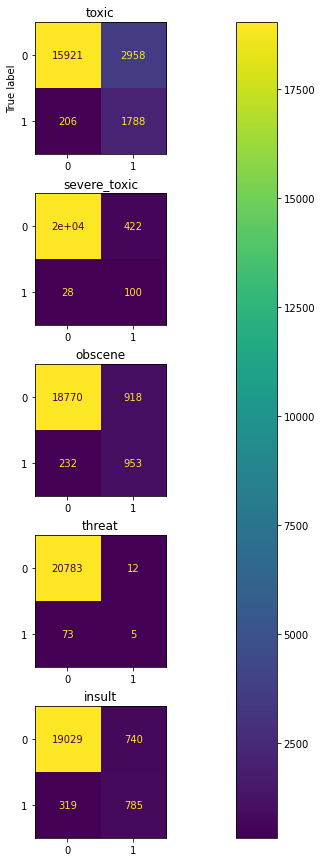

In [73]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix


def classification_report(
        real, prob, tresh=0.2
):
    

        _, roc_auc = comp_metric(real, prob)
        print( f"ROC-AUC: {roc_auc}\n" )

        _, accuracy = comp_metric_accuracy_score(real, prob > tresh)
        print( "Accuracy :", accuracy)

        for cls_idx, cls_name in enumerate(criteria):
          plt.title(f"{cls_name} Real vs Pred distribution")
          plt.hist((real[:, cls_idx]), bins=30, label="Real")
          plt.hist((prob[:, cls_idx]), bins=30, label="Pred")
          plt.legend()
          plt.show()

        cm = multilabel_confusion_matrix(
            real, 
            prob > tresh, 
        )

        print("\nconfusion matrix\n",cm)



        # disp = ConfusionMatrixDisplay(
        #     confusion_matrix=cm, 
        # )
        # disp.plot()
        # plt.show()
        f, axes = plt.subplots( 5, figsize=(25, 15))

        for i in range(5):
          disp = ConfusionMatrixDisplay(confusion_matrix(real[:, i],
                                                        prob[:, i] > tresh),
                                        )
          disp.plot(ax=axes[i])
          disp.ax_.set_title(criteria[i])
          if i<10:
              disp.ax_.set_xlabel('')
          if i%5!=0:
              disp.ax_.set_ylabel('')
          disp.im_.colorbar.remove()

        plt.subplots_adjust(wspace=0.10, hspace=0.3)
        f.colorbar(disp.im_, ax=axes)
        plt.show()

   

classification_report(test_targets, test_labels)    

# **Word2Vec or Flair word embeddings and use them instead of torch.nn.Embedding.**






In [ ]:
model = gensim.models.Word2Vec(df.iloc[folds_train_test_ids[0][0]]["comment_text_clean"].apply(str.split),
                              min_count=10, 
                              workers=1,
                              size=50,
                              window=5,
                              iter = 10)

In [ ]:
weights = torch.FloatTensor(model.wv.vectors)
embeddings_w2vec = nn.Embedding.from_pretrained(weights)

In [ ]:
query = 'i'
query_id = torch.tensor(model.wv.vocab[query].index)
embedding_vector = embeddings_w2vec(query_id)
embedding_vector



tensor([-0.2211,  0.1706,  2.3974, -0.2003,  2.0290, -1.1812,  0.6146,  1.8350,
        -0.6323, -1.5949,  0.9808,  0.6322,  0.0566, -0.1322,  0.9298,  0.5680,
         0.2433,  0.8010,  0.9081,  0.7154, -0.2160, -0.2291,  0.2417, -0.5295,
         0.3707,  1.6581,  3.5173,  1.6413,  2.0982, -0.3521,  1.8757, -2.8537,
        -0.6446,  2.7627, -1.4350,  0.9809,  3.6598,  2.7015,  0.7482, -0.1936,
         2.3844, -0.8660, -3.6676, -1.1592,  1.7485, -1.4312,  0.3128, -2.1809,
        -0.1870,  0.1200])

In [ ]:
model.most_similar(positive=['i', 'ask'], negative=['please'], topn=1)

<ipython-input-19-e9ad4ded78b1>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive=['i', 'ask'], negative=['please'], topn=1)


[('happen', 0.5742165446281433)]

In [ ]:
class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=50,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=False,
        average_type=None
    ):
        super().__init__()
        
        # self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)

        self.embedding_layer = embeddings_w2vec

        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is not supported average_type")
        self.average_type = average_type
        self.classifier = nn.Linear(
            rnn_channels * 2 if bidirectional else rnn_channels, 
            out_channels, 
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

In [ ]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),

    out_channels=len(criteria),
    average_type="mean"
).to("cuda")

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")

optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [ ]:

n_epochs = 3

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None


for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="train"
    )
    print("Train metrics")
    _, train_roc_auc = comp_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="eval"
    )
    print("Valid metrics")
    _, valid_roc_auc = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    scheduler.step(valid_roc_auc)
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())

      
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses.mean())
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses.mean())
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)